- v1: deal with missing value
- v2: try change the method of replace missing value
    * village_income_median use old method

## 玉山人工智慧公開挑戰賽2019夏季賽 - 台灣不動產AI神預測 

- House price: Predict sales prices
- 購買屬於自己的房子，是我們一生中的大事，評估房子的好壞，不僅要考慮房子的大小、屋齡，甚至連附近的生活機能和未來發展性都是一大考量因素。然而在眾多的考量中，什麼才是影響房價高低至關重要的因素呢？

In [1]:
import numpy as np
import pandas as pd
import re
from tqdm import tqdm


from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import r2_score


from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso
import lightgbm as lgb

import scipy.stats as stats
import math
import gc


import hyperopt
from hyperopt import hp
from hyperopt import tpe
from hyperopt import Trials
from hyperopt import fmin
import csv
from timeit import default_timer as timer
from hyperopt import STATUS_OK, hp, tpe, Trials, fmin
import ast

from numpy.random import RandomState



import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Load the data

In [2]:
train = pd.read_csv("../input/house-data/train.csv")
test = pd.read_csv("../input/house-data/test.csv")

print("Train ", train.shape[0], "sales, and ", train.shape[1], "features" )
print("Test ", test.shape[0], "sales, and ", test.shape[1], "features" )

Train  60000 sales, and  235 features
Test  10000 sales, and  234 features


### EDA

There are 60,000 instances of training data and 10000 of test data. Total number of attributes equals 235, of which 233 is quantitative, Id (qualitative) and SalePrice. -> all are quantitative except ID

- **Missing Value**: 4 features have missing value in both train and test data: 'village_income_median', 'txn_floor', 'parking_price', 'parking_area'

- **Normal Distributaion on total price**: total_price doesn't follow normal distribution, so before performing regression it has to be transformed -> use standardisation since log total price follow gaussian distribution

- Data is non-linear

In [3]:
quantitative = [f for f in train.columns if train[f].dtypes != 'object']
#quantitative.remove('total_price')
qualitative = [f for f in train.columns if train[f].dtypes == 'object']
print("qualitative data:", qualitative)

qualitative data: ['building_id']


In [4]:
print("train data type: ", train.get_dtype_counts())
print("test data type: ", test.get_dtype_counts())

train data type:  float64     37
int64      197
object       1
dtype: int64
test data type:  float64     36
int64      197
object       1
dtype: int64


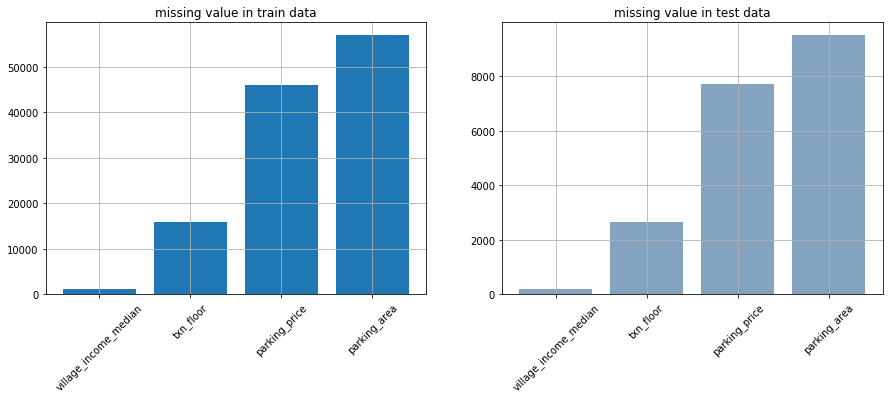

In [5]:
tr_missing = train.isnull().sum()
tr_missing = tr_missing[tr_missing > 0]
tr_missing.sort_values(inplace=True)
tr_missing = pd.DataFrame(tr_missing).reset_index()
tr_missing = tr_missing.rename(columns = {"index": "features", 0:"count"})

te_missing = test.isnull().sum()
te_missing = te_missing[te_missing > 0]
te_missing.sort_values(inplace=True)
te_missing = pd.DataFrame(te_missing).reset_index()
te_missing = te_missing.rename(columns = {"index": "features", 0:"count"})


def plot_missing(df_train, df_test):
    
    plt.figure(figsize=(15, 5)) 
    
    plt.subplot(1,2,1)
    plt.grid(b=None) # no grid line
    plt.bar(df_train["features"], df_train["count"])
    plt.title("missing value in train data", loc='center')
    plt.xticks(rotation=45)
    
    plt.subplot(1,2,2)
    plt.grid(b=None) # no grid line
    plt.bar(df_test["features"], df_test["count"], color=(0.2, 0.4, 0.6, 0.6))
    plt.title("missing value in test data", loc='center')
    plt.xticks(rotation=45)
    
    plt.show()
    
plot_missing(tr_missing, te_missing)

Text(0.5, 1.0, 'Normal Distribution with log transform for total price (train)')

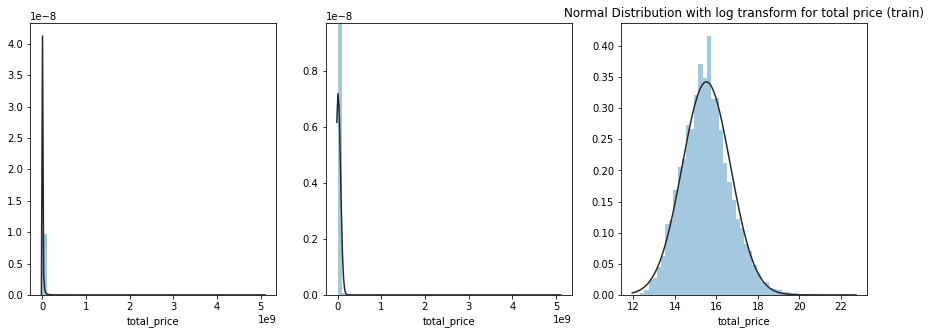

In [6]:
y = train['total_price']
log_price = train["total_price"].apply(lambda row: math.log(row))

f, axes = plt.subplots(1, 3, figsize=(15,5))

sns.distplot(y, kde=False, fit=stats.johnsonsu, ax = axes[0])
plt.title('Johnson SU')

sns.distplot(y, kde=False, fit=stats.norm, ax = axes[1])
plt.title('Normal Distribution')

sns.distplot(log_price, kde=False, fit=stats.norm, ax = axes[2])
plt.title('Normal Distribution with log transform for total price (train)')

In [7]:
# The Shapiro-Wilk test evaluates a data sample and quantifies how likely it is that the data was drawn from a Gaussian distribution
warnings.filterwarnings("ignore")

test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
normal = pd.DataFrame(train[quantitative])
normal = normal.apply(test_normality)

# not reject null hypothesis -> features with normal distribution
print("features with normal distribution: \n", list(pd.DataFrame(normal[normal==False]).reset_index()["index"])) 

features with normal distribution: 
 ['I_index_5000', 'I_index_10000', 'II_index_5000', 'II_index_10000', 'III_index_5000', 'III_index_10000', 'IV_index_10000', 'V_index_5000', 'V_index_10000', 'VI_index_5000', 'VI_index_10000', 'VII_index_5000', 'VII_index_10000', 'VIII_index_5000', 'VIII_index_10000', 'IX_index_10000', 'X_index_5000', 'X_index_10000', 'XII_index_5000', 'XII_index_10000', 'XIV_index_5000', 'XIV_index_10000']


In [8]:
# Data is non-linear (skip first -> take too long)

# features = [col for col in train.columns if col not in ["building_id", "total_price"]]
# model = TSNE(n_components=2, random_state=0, perplexity=50)

# X = train[features].fillna(0).values
# tsne = model.fit_transform(X)

# std = StandardScaler()
# s = std.fit_transform(X)

# pca = PCA(n_components=30)
# pca.fit(s)
# pc = pca.transform(s)
# kmeans = KMeans(n_clusters=5)
# kmeans.fit(pc)

# fr = pd.DataFrame({'tsne1': tsne[:,0], 'tsne2': tsne[:, 1], 'cluster': kmeans.labels_})
# sns.lmplot(data=fr, x='tsne1', y='tsne2', hue='cluster', fit_reg=False)
# print(np.sum(pca.explained_variance_ratio_))

### Handle Missing Value
- village_income_median
- txn_floor
- parking_price
- parking_area

Note: 
1. whether should comebine train and test to replace the missing value 
2. strong assumption on if park_way==2 -> parking_area & parking_price = 0 <br/>
    (found: parking_way==2 -> parking_price=na and parking_area=na)



In [9]:
test["total_price"] = -1
all_df = pd.concat([train, test])

print("# of missing value in village income median (all): ", all_df["village_income_median"].isnull().sum())
print("# of missing value in village income median (train): ", train["village_income_median"].isnull().sum())
print("# of missing value in village income median (test): ", test["village_income_median"].isnull().sum())

# of missing value in village income median (all):  1326
# of missing value in village income median (train):  1142
# of missing value in village income median (test):  184


In [10]:
#----------------------------------------------
# remove column with no variation
#----------------------------------------------

print("data shape: ", all_df.shape)
original_columns = all_df.columns
all_df = all_df.loc[:,all_df.apply(pd.Series.nunique) != 1]
new_columns = all_df.columns
print("data shape after removing columns with no variation: ", all_df.shape)
print("columns with no variation:", list(set(original_columns)-set(new_columns)))

data shape:  (70000, 235)
data shape after removing columns with no variation:  (70000, 213)
columns with no variation: ['VIII_index_5000', 'IV_index_10000', 'IX_index_10000', 'II_index_10000', 'XII_index_10000', 'VII_index_10000', 'V_index_10000', 'VIII_index_10000', 'VII_index_5000', 'III_index_10000', 'V_index_5000', 'XIV_index_10000', 'X_index_10000', 'II_index_5000', 'I_index_10000', 'X_index_5000', 'I_index_5000', 'VI_index_10000', 'XIV_index_5000', 'XII_index_5000', 'III_index_5000', 'VI_index_5000']


In [11]:
# get possiblely categorical variable (need to add txn_floor into it) [5/5]
categorical_var=[]
for col in all_df:
    if len(all_df[col].unique())>1 and all_df[col].dtypes=="int64":
        #print (col, "-> unique value: ", train[col].unique())
        categorical_var.append(col)

categorical_var.append("txn_floor")

not_categorical_var = set(all_df.columns)-set(categorical_var) # not categorical_var

In [12]:
# should remove certain from the categorical variable list
to_remove = [i for i in categorical_var if re.search("^[A-Z]{1,5}[_]\d{1,5}$", i, re.IGNORECASE)!=None] 
categorical_var = list(set(categorical_var)-set(to_remove))
print(categorical_var)

['VII_index_1000', 'V_index_50', 'town', 'building_material', 'I_index_1000', 'txn_dt', 'III_index_50', 'V_index_1000', 'city', 'VI_index_50', 'XIII_index_10000', 'III_index_1000', 'VIII_index_500', 'XIII_index_5000', 'XIII_index_1000', 'VII_index_500', 'XI_index_10000', 'II_index_50', 'IV_index_5000', 'III_index_500', 'XII_index_500', 'VIII_index_50', 'XIII_index_500', 'XI_index_1000', 'X_index_1000', 'XII_index_50', 'II_index_500', 'I_index_500', 'X_index_500', 'XIV_index_1000', 'parking_way', 'building_use', 'txn_floor', 'X_index_50', 'building_type', 'XI_index_5000', 'IV_index_500', 'XII_index_1000', 'village', 'XI_index_500', 'XIV_index_50', 'IX_index_5000', 'VIII_index_1000', 'XIII_index_50', 'IV_index_50', 'V_index_500', 'building_complete_dt', 'XI_index_50', 'I_index_50', 'total_floor', 'VI_index_1000', 'IX_index_1000', 'IX_index_500', 'VI_index_500', 'IX_index_50', 'VII_index_50', 'XIV_index_500', 'IV_index_1000', 'II_index_1000']


In [13]:
#----------------------------------------------
# missing value in "parking_area", "parking_price"
#----------------------------------------------

missing_col = ["parking_area", "parking_price"]
for col in missing_col:
    all_df["has"+col] = np.where(all_df[col]>0,1,0)

In [14]:
#----------------------------------------------
# group data into diff group based on some columns
# strong assumption: those are same building but diff floor
#----------------------------------------------

train1 = all_df[:len(train)]
test1 = all_df[len(train):]

group_col = train1.columns[12:]
group_col = [col for col in group_col if col !="total_price"]

t = train1.groupby(by=group_col).size().reset_index()
t = t.rename(columns={0:"count_in_train"})
t["group_index"] = t.index

merge_col = [col for col in t.columns if col not in ["count_in_train","group_index"]]

train1 = pd.merge(train1, t , how="left", on = merge_col)
test1 = pd.merge(test1, t , how="left", on = merge_col)

In [15]:
all_df2 = pd.concat([train1, test1])

# only predict for groups with >= 5 count in train
all_df3 = all_df2[all_df2["count_in_train"]>=5]
train2 = all_df3[all_df3["total_price"]!=-1]
test2 = all_df3[all_df3["total_price"]==-1]

In [16]:
#remaining_no_group = all_df2[pd.isnull(all_df2["count_in_train"])]

group_index_list = [i for i in set(all_df3["group_index"]) if pd.notnull(i)]
index_in_both_list = list(train2[train2["group_index"].isin(test2["group_index"])]["group_index"].unique())

col_predict = ["building_complete_dt","parking_way", 
               "txn_floor", "building_type",
               "building_use","building_material","city","txn_dt" ]
 
    
train3 = train2[train2["group_index"].isin(index_in_both_list)]  
test3 = test2[test2["group_index"].isin(index_in_both_list)]   
    
predictions_list = []
building_id_list = []

for i in index_in_both_list:
    tr = train3[train3["group_index"]==i]
    te = test3[test3["group_index"]==i]
    tr["txn_floor"] = tr["txn_floor"].fillna(4)
    te["txn_floor"] = te["txn_floor"].fillna(4)
    
    building_id_list_c = te["building_id"].values.tolist()
    building_id_list.append(building_id_list_c)

    target = tr["total_price"]
    tr = tr.drop("total_price", axis=1)
    te = te.drop("total_price", axis=1)
    lm = LinearRegression()
    lm.fit(tr[col_predict], target)
    predictions = lm.predict(te[col_predict])
    predictions = predictions.tolist()
    predictions_list.append(predictions)



In [17]:
adjust_predictions = pd.DataFrame([j for i in predictions_list for j in i])
adjust_building = pd.DataFrame([j for i in building_id_list for j in i])
adjust_building_file = pd.concat([adjust_building, adjust_predictions], axis=1)

In [18]:
adjust_building_file.columns = ["building_id", "total_price_new"]

In [19]:
lgbm = pd.read_csv("../input/lgbm-1987-output/190509_lgbm_1987.csv")

In [20]:
final = pd.merge(lgbm, adjust_building_file, how="left", on="building_id")

In [21]:
final["total_price_new1"] = final.apply(lambda row: row["total_price_new"] 
                                       if pd.notnull(row["total_price_new"]) 
                                       else row["total_price"], axis=1)

In [22]:
final = final[["building_id", "total_price_new1"]]
final = final.rename(columns={"total_price_new1": "total_price_new"})

In [23]:
final.to_csv("new_lgbm_file.csv", index=False)

In [24]:
    #building_id_df.append(te)
    
#     if te.shape[0]>0:
#         target = tr["total_price"]
#         tr = tr.drop("total_price", axis=1)
#         te = te.drop("total_price", axis=1)
#         lm = LinearRegression()
#         lm.fit(tr[col_predict], target)
#         predictions = lm.predict(te[col_predict])
